## Mean Shift
Mean Shift is very similar to the K-Means algorithm, except for one very important factor: you do not need to specify the number of groups prior to training. The Mean Shift algorithm finds clusters on its own. For this reason, it is even more of an "unsupervised" machine learning algorithm than K-Means.  

This type of clustering is also called as hierarchical clustering method.

## Working
The way Mean Shift works is to go through each featureset, and proceed to do a hill climb operation. The idea is to continually increase, or go up, until you cannot anymore.  
We don't have for sure just one local maximal value. We might have only one, or we might have ten. Our "hill" in this case will be the number of featuresets within a given radius. The radius is also called a bandwidth, and the entire window is your Kernel. The more data within the window, the better.  
Once we can no longer take another step without decreasing the number of featuresets within the radius, we take the mean of all data in that region and we have located a cluster center. We do this starting from each data point. Many data points will lead to the same cluster center, which should be expected, but it is also possible that other data points will take you to a completely separate cluster center.  

**What is Mean Shift used for?** Along with the clustering uses mentioned before, Mean Shift is also very popular in image analysis for both tracking and smoothing.

Lets start with coding!

In [1]:
import numpy as np

from sklearn.cluster import MeanShift
from sklearn.datasets.samples_generator import make_blobs

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
style.use("ggplot")

f:\projects\myprojects\machinelearning\mlenv\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Lets create some sample data.
We are going to make use of **make_blobs** function to generate data for specific centroids.

In [2]:
centers = [[1,1,1],[5,5,5],[3,10,10]]

X, _ = make_blobs(n_samples = 100, centers = centers, cluster_std = 1.5)

## Training

In [3]:
ms = MeanShift()
ms.fit(X)

MeanShift()

Lets see the estimated clusters and compare with the centre we specified.

In [4]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_

print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters_)

[[2.2972135  2.66300059 2.49905964]
 [3.30849504 9.61573897 9.36548886]]
Number of estimated clusters: 2


Lets plot the data

<IPython.core.display.Javascript object>


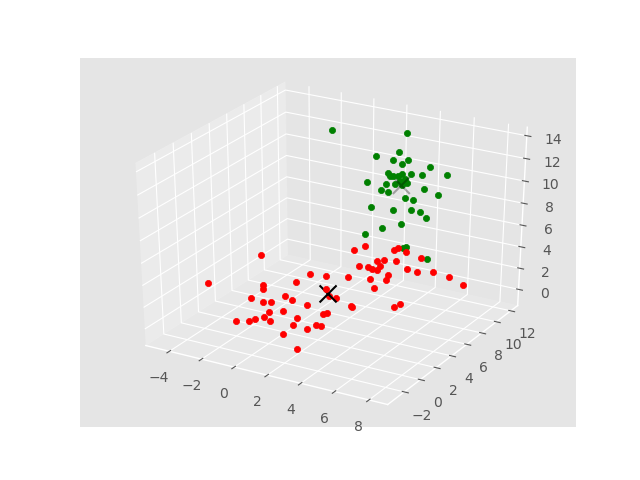

In [5]:
# for interactive 3-D plot
%matplotlib notebook    

colors = 10*['r','g','b','c','k','y','m']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X)):
    ax.scatter(X[i][0], X[i][1], X[i][2], c=colors[labels[i]], marker='o')

ax.scatter(cluster_centers[:,0],cluster_centers[:,1],cluster_centers[:,2],
            marker="x",color='k', s=150, linewidths = 5, zorder=10)

plt.show()

Lets apply Mean Shift on Titanic dataset.  
(Lets use the code from K-Means for data cleaning)

In [6]:
import numpy as np
import pandas as pd

from sklearn.cluster import MeanShift
from sklearn import preprocessing

import matplotlib.pyplot as plt

df = pd.read_excel('data/titanic.xls')

# lets keep the copy of original dataframe (before cleaning it) for future analysis
original_df = pd.DataFrame.copy(df)
df.drop(['body','name'], 1, inplace=True)
df.fillna(0,inplace=True)

def handle_non_numerical_data(df):
    
    # handling non-numerical data: must convert.
    columns = df.columns.values

    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        #print(column,df[column].dtype)
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1
            
            df[column] = list(map(convert_to_int,df[column]))

    return df

df = handle_non_numerical_data(df)
df.drop(['ticket','home.dest'], 1, inplace=True)

X = np.array(df.drop(['survived'], 1).astype(float))
X = preprocessing.scale(X)
y = np.array(df['survived'])

## Training

In [7]:
clf = MeanShift()
clf.fit(X)

MeanShift()

Lets retreive couple of attributes we need from the classifier

In [8]:
labels = clf.labels_
cluster_centers = clf.cluster_centers_

Lets add a *'cluster_group'* column to our original dataframe and fill it with labels(cluster groups) generated by our classifier.

In [9]:
original_df['cluster_group']=np.nan

for i in range(len(X)):
    original_df['cluster_group'].iloc[i] = labels[i]

f:\projects\myprojects\machinelearning\mlenv\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Data Analysis
Now lets try to extract some meaningful data out of the clusters. 

Lets check the survival rates for each cluster group

In [10]:
n_clusters_ = len(np.unique(labels))

survival_rates = {}

for i in range(n_clusters_):
    temp_df = original_df[(original_df['cluster_group'] == float(i))]
    
    survival_cluster = temp_df[(temp_df['survived'] == 1)]
    
    survival_rate = len(survival_cluster) / len(temp_df)
    survival_rates[i] = survival_rate

survival_rates

{0: 0.37811745776347544,
 1: 1.0,
 2: 0.1,
 3: 0.5714285714285714,
 4: 0.4166666666666667}

Lets understand the above result.  

What we got is 4 cluster groups each with survival rates as below:  
**Cluster Group 0: 35%  
Cluster Group 1: 82%  
Cluster Group 2: 100%  
Cluster Group 3: 10%**  
(The output i.e. number of cluster groups may vary)  
**Note:** We don't know why the classifier divided the data into 4 groups. What we are trying to do is find a correlation between survival rate and the unsupervised cluster groups.

Now lets extract the data of each cluster group and see if we can find out something.

In [11]:
for i in range(len(survival_rates)):
    print(f"Group {i}: ", original_df[ (original_df['cluster_group'] == i) ].describe()['pclass']['mean'])

Group 0:  2.333065164923572
Group 1:  1.0
Group 2:  3.0
Group 3:  1.0
Group 4:  1.5


What above result tells us is that:  
- passengers in **'Group 0'** on an average belong to **'Second Class'** and they have around **35%** survival rate. (This group consists of lot of data with a mix of 2nd and 3rd class people).
- passengers in **'Group 1'** on an average belong to **'First Class'** and they have around **82%** survival rate. 
- passengers in **'Group 2'** on an average belong to **'First Class'** and they have around **100%** survival rate.  
- passengers in **'Group 3**' on an average belong to **'Third Class'** and they have around **10%** survival rate.


Now lets see what each cluster group constitutes (i.e. each group contains how many number of passengers belonging to different classes) along with their survival rates. 

In [12]:
print("Number of people belonging to each class in: ")
for i in range(len(survival_rates)):
    print(f"\nGroup {i}\n" + "-"*20)
    print(original_df[ (original_df['cluster_group'] == i) ].groupby('pclass')['name'].nunique())
    print("Survival Rate: ", survival_rates[i])


Number of people belonging to each class in: 

Group 0
--------------------
pclass
1    276
2    277
3    688
Name: name, dtype: int64
Survival Rate:  0.37811745776347544

Group 1
--------------------
pclass
1    6
Name: name, dtype: int64
Survival Rate:  1.0

Group 2
--------------------
pclass
3    10
Name: name, dtype: int64
Survival Rate:  0.1

Group 3
--------------------
pclass
1    14
Name: name, dtype: int64
Survival Rate:  0.5714285714285714

Group 4
--------------------
pclass
1    27
3     9
Name: name, dtype: int64
Survival Rate:  0.4166666666666667


Lets check what is the survival rate of the 1st class passengers in cluster 0, compared to the overall survival rate of cluster 0

In [13]:
cluster_0 = (original_df[(original_df['cluster_group'] == 0)])
cluster_0_fc = (cluster_0[(cluster_0['pclass'] == 1)])
cluster_0_fc.describe()['survived']['mean']

0.6195652173913043

So that means, the 1st class passengers have a better survival rate (54%) when compared to everyone else in that cluster (35%)  

**NOTE**: This might change when you run it again